In [1]:
import numpy as np
import pandas as pd
import trimesh
import slam.io as sio
import nibabel as nib
from mne import read_epochs
from freesurfer_tools import transform_atlas, fsavg_vals_to_native
import matplotlib
matplotlib.use("Qt5Agg")
from matplotlib import cm, colors
import matplotlib.pylab as plt
import new_files
files = new_files.Files()
from sklearn.preprocessing import minmax_scale
from scipy.interpolate import interp2d, interp1d
from scipy.spatial.distance import euclidean
from scipy.signal import savgol_filter

In [2]:
def compute_csd(surf_tcs, times, mean_dist, n_surfs):
    # Compute CSD
    nd=1;
    spacing=mean_dist*10**-3

    csd=np.zeros((n_surfs, surf_tcs.shape[1]))
    for t in range(surf_tcs.shape[1]):
        phi=surf_tcs[:,t]
        csd[0,t]=surf_tcs[0,t]
        csd[1,t]=surf_tcs[1,t]
        for z in range(2,n_surfs-3):
            csd[z,t]=(phi[z+2]-2*phi[z]+phi[z-2])/((nd*spacing)**2)
        csd[-2,t]=surf_tcs[-2,t]
        csd[-1,t]=surf_tcs[-1,t]            
    
    return csd

def csd_layer(data, mean_distance, n_surfs, nd=1):
    spacing = mean_distance*10*1e-3
    output_shape = data.shape
    csd = np.zeros(output_shape)
    for t in range(output_shape[1]):
        phi = data[:, t]
        csd[0, t] = data[0, t]
        csd[1, t] = data[1, t]
        for z in range(2, n_surfs-3):
            csd[z, t] = (phi[z+2]-2*phi[z-2])/((nd*spacing)**2)
        csd[-2, t] = data[-2, t]
        csd[-1, t] = data[-1, t]  
    return csd


def smooth_csd(csd, n_surfs):
    # interpolate CSD in space
    y = np.linspace(0,n_surfs-1,n_surfs)
    Yi=np.linspace(0,n_surfs-1,500)
    
    f=interp1d(y,csd,kind='cubic',axis=0)
    csd_smooth=f(Yi)
    
    csd_smooth=savgol_filter(csd_smooth, 51, 3, axis=1)
    
    return csd_smooth

In [3]:
glasser = "/home/mszul/git/DANC_multilayer_laminar/assets/atlas_glasser_2016.csv"
dataset_path = "/home/common/bonaiuto/cued_action_meg/derivatives/processed/"
fsavg_sphere_paths = [
    "/home/mszul/git/DANC_multilayer_laminar/assets/lh.sphere.reg.gii",
    "/home/mszul/git/DANC_multilayer_laminar/assets/rh.sphere.reg.gii"
]
annot_paths = [
    "/home/mszul/git/DANC_multilayer_laminar/assets/lh.HCPMMP1.annot",
    "/home/mszul/git/DANC_multilayer_laminar/assets/rh.HCPMMP1.annot"
]
thicc_l_paths = files.get_files("/home/mszul/git/DANC_multilayer_laminar/assets/big_brain_layer_thickness", "*.gii", strings=["hemi-L"], prefix="tpl-fsaverage")
thicc_r_paths = files.get_files("/home/mszul/git/DANC_multilayer_laminar/assets/big_brain_layer_thickness", "*.gii", strings=["hemi-R"], prefix="tpl-fsaverage")
thicc_lr_paths = list(zip(thicc_l_paths, thicc_r_paths))

In [4]:
def get_necessary_files(subject_id, dataset_path, *kwargs):
    all_mu_files = files.get_files(dataset_path, "*.tsv", strings=[subject_id, *kwargs], prefix="multilayer_MU")
    all_epoch_files = files.get_files(dataset_path, "*.fif", strings=[subject_id, "epo", *kwargs], prefix="autoreject")
    all_behav_files = files.get_files(dataset_path, "*.csv", strings=[subject_id, "beh", *kwargs], prefix="autoreject")
    all_pial_path = files.get_files(dataset_path, "*.gii")
    fsnat_sphere_lh = [i for i in all_pial_path if files.check_many([subject_id, "lh.sphere.reg.gii"], i, func="all")][0]
    fsnat_sphere_rh = [i for i in all_pial_path if files.check_many([subject_id, "rh.sphere.reg.gii"], i, func="all")][0]
    fsnat_sphere_paths = [fsnat_sphere_lh, fsnat_sphere_rh]
    pial_path = [i for i in all_pial_path if files.check_many([subject_id, "/pial.gii"], i, func="all")][0]
    pial_ds_path = [i for i in all_pial_path if files.check_many([subject_id, "/pial.ds.gii"], i, func="all")][0]
    pial_ds_nodeep = [i for i in all_pial_path if files.check_many([subject_id, "pial.ds.link_vector.nodeep.gii"], i, func="all")][0]
    white_ds_nodeep = [i for i in all_pial_path if files.check_many([subject_id, "white.ds.link_vector.nodeep.gii"], i, func="all")][0]
    pial_ds_inflated = [i for i in all_pial_path if files.check_many([subject_id, "pial.ds.inflated.nodeep.gii"], i, func="all")][0]
    return all_mu_files, all_epoch_files, all_behav_files, fsnat_sphere_paths, pial_path, pial_ds_path, pial_ds_nodeep, white_ds_nodeep, pial_ds_inflated

In [5]:
[
    all_mu_files, all_epoch_files, all_behav_files, 
    fsnat_sphere_paths, pial_path, pial_ds_path, 
    pial_ds_nodeep, white_ds_nodeep, pial_ds_inflated
] = get_necessary_files("sub-001", dataset_path, "visual1")

In [6]:
print(fsnat_sphere_paths, pial_path, pial_ds_path, pial_ds_nodeep, white_ds_nodeep, pial_ds_inflated)

['/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/lh.sphere.reg.gii', '/home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/rh.sphere.reg.gii'] /home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/pial.gii /home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/pial.ds.gii /home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/pial.ds.link_vector.nodeep.gii /home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/white.ds.link_vector.nodeep.gii /home/common/bonaiuto/cued_action_meg/derivatives/processed/sub-001/fs/surf/pial.ds.inflated.nodeep.gii


In [7]:
pial_ds_loc = nib.load(pial_ds_nodeep).agg_data()[0]
white_ds_loc = nib.load(white_ds_nodeep).agg_data()[0]
distance_ROI = np.array([euclidean(pial_ds_loc[i], white_ds_loc[i]) for i in range(pial_ds_loc.shape[0])])

In [8]:
filtered = True

if filtered:
    mu_files = [i for i in all_mu_files if "_filt_" in i]
else:
    mu_files = [i for i in all_mu_files if "_nofilt_" in i]

In [9]:
mesh_colors, lab_col_map = transform_atlas(annot_paths, fsavg_sphere_paths, fsnat_sphere_paths, pial_path, pial_ds_path, pial_ds_nodeep)

In [11]:
atlas = pd.read_csv(glasser)
target_labels = atlas[
    (atlas.PRIMARY_SECTION == 1) | 
    (atlas.USED_LABEL == "L_MT_ROI") | 
    (atlas.USED_LABEL == "R_MT_ROI")
].USED_LABEL.to_list()
print(target_labels)

['L_V1_ROI', 'L_MT_ROI', 'R_V1_ROI', 'R_MT_ROI']


In [12]:
ROI_maps = {i: [i == j.decode("utf=8") for j in lab_col_map] for i in target_labels}

In [15]:
layers_fsaverage_values = {i+1: [nib.load(i).agg_data() for i in thicc_lr_paths[i]] for i in range(len(thicc_lr_paths))}
layers_fsnative_ds_values = {i: fsavg_vals_to_native(
    layers_fsaverage_values[i],
    fsavg_sphere_paths,
    fsnat_sphere_paths, 
    pial_path, 
    pial_ds_path, 
    pial_ds_nodeep
) for i in layers_fsaverage_values.keys()}

In [16]:
layers = np.array([layers_fsnative_ds_values[i] for i in layers_fsnative_ds_values.keys()])
overall_thickness = np.sum(layers, axis=0)
layers_prop_thickness = {i: np.divide(
    layers_fsnative_ds_values[i], 
    overall_thickness, 
    where=overall_thickness != 0
) for i in layers_fsnative_ds_values.keys()}

In [17]:
# pd.read_csv(all_behav_files[0]).trial_coherence
beh_epo = list(zip(all_behav_files, all_epoch_files, mu_files))
for beh_path, epo_path, MU_path in [beh_epo[0]]:
    beh = pd.read_csv(beh_path).trial_coherence
    map_low = (beh == "low").to_numpy()
    map_med = (beh == "med").to_numpy()
    map_high = (beh == "high").to_numpy()
    epo = read_epochs(epo_path, verbose=False)
    times = epo.times
    epo = epo.pick_types(meg=True, ref_meg=False, misc=False)
    epo = epo.get_data()
    MU = pd.read_csv(MU_path, sep="\t", header=None).to_numpy()
    MU = np.split(MU, 11, axis=0)
    MU = MU[::-1]
    source = {}
    for i in target_labels:
        # layers x epochs x vertices x time
        data = np.array([np.array([np.dot(m[ROI_maps[i]], e) for e in epo]) for m in MU])
        source[i] = [data[:, map_low, :], data[:, map_med, :], data[:, map_high, :]]

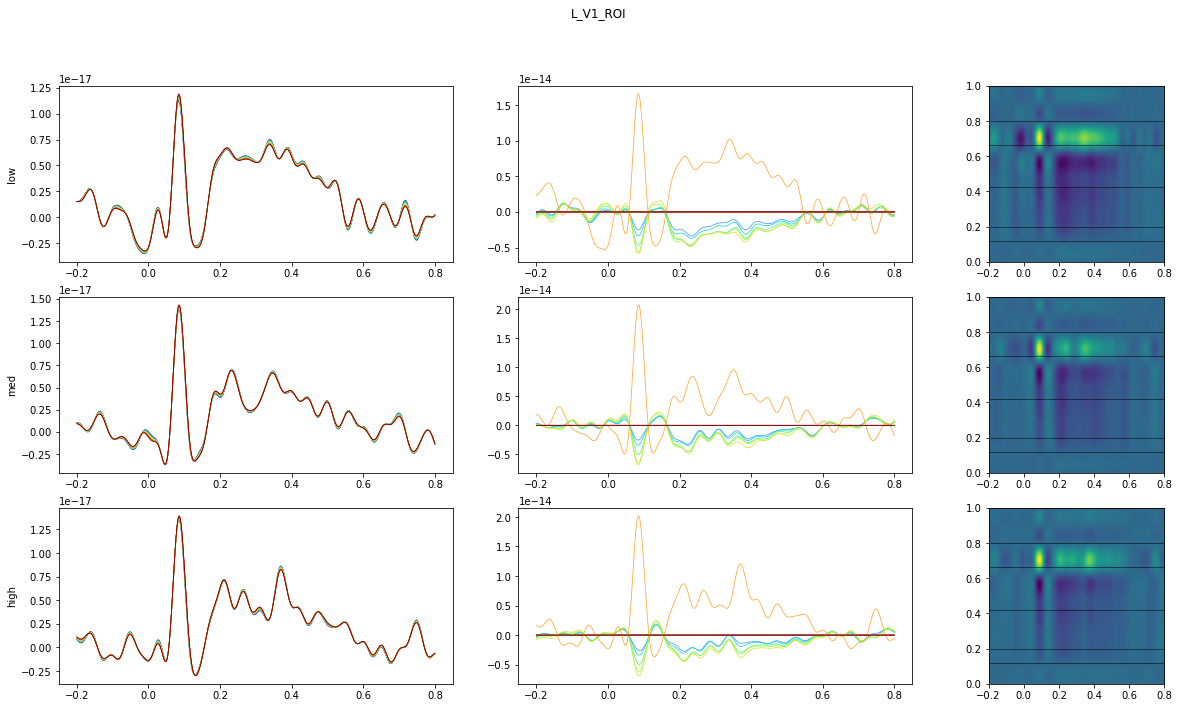

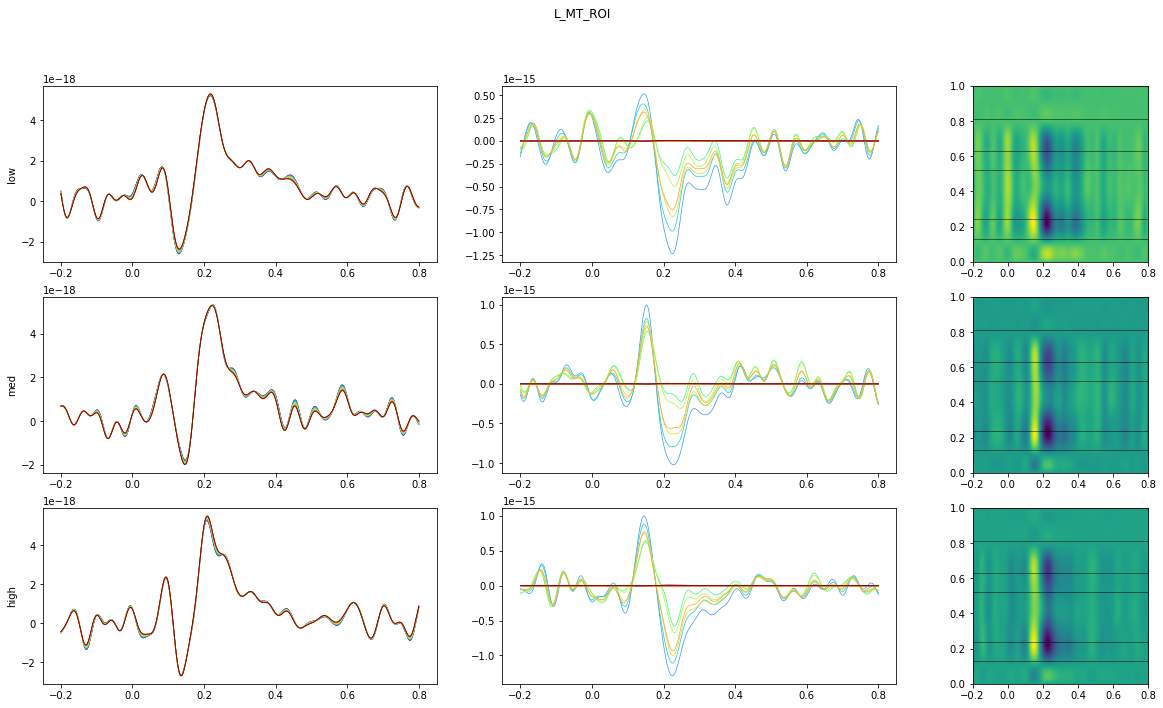

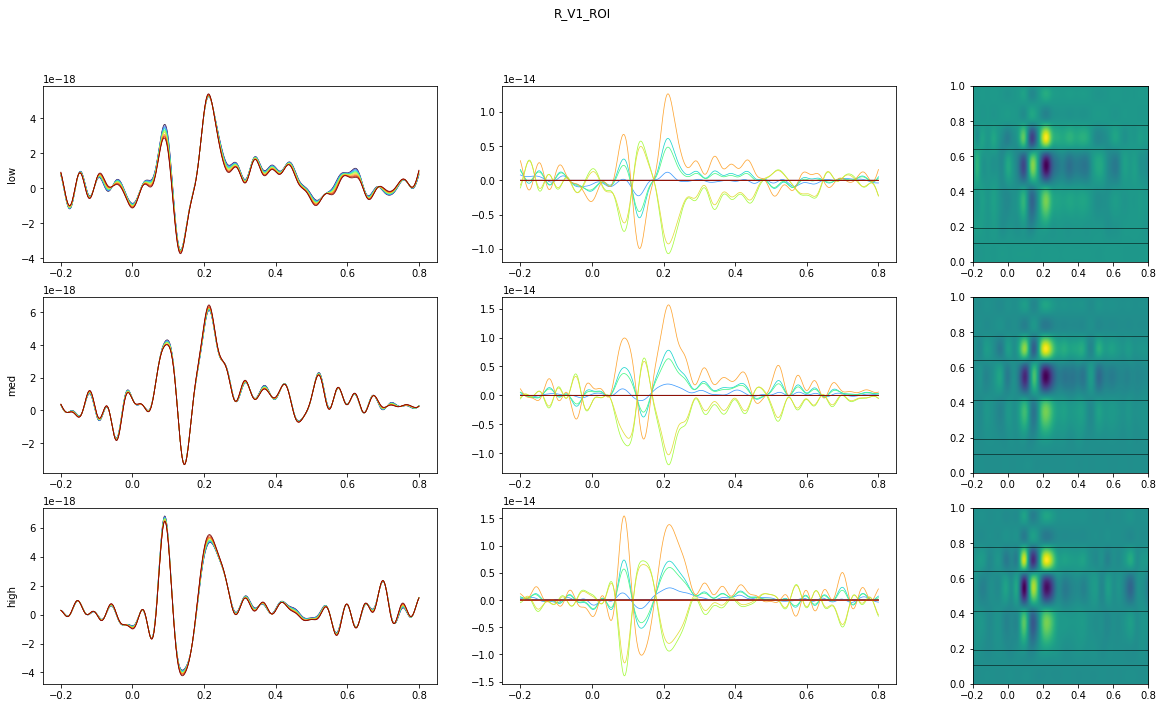

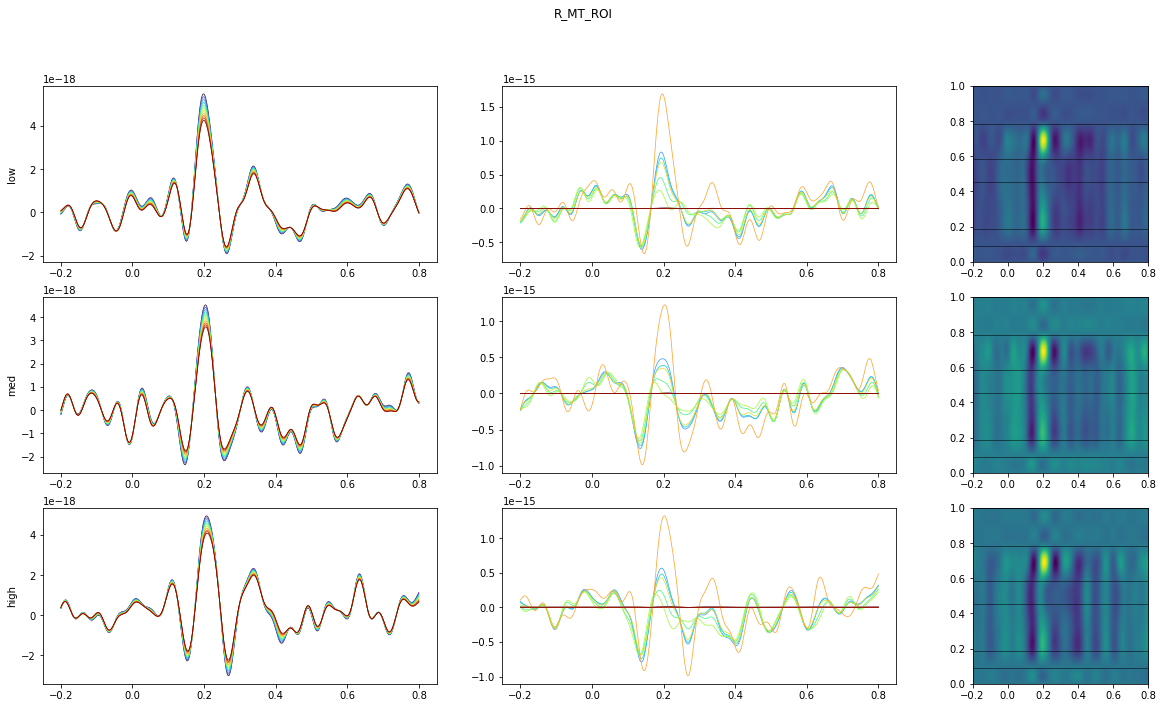

In [159]:
%matplotlib inline

n_surfs = 11
colour_range = plt.cm.turbo(np.linspace(0, 1, num=n_surfs))


for ix, lab in enumerate(target_labels):
    lab_vx_ix = np.arange(len(ROI_maps[lab]))[ROI_maps[lab]]
    
    layer_thiccness = []
    for lay in layers_prop_thickness.keys():
        layer_thiccness.append(layers_prop_thickness[lay][lab_vx_ix])
    layer_thiccness = np.array(layer_thiccness)
    mean_ROI_thicc = np.mean(np.cumsum(layer_thiccness, axis=0), axis=1)
    
    low, med, high = source[lab]
    std_vx = np.std(np.concatenate(source[lab], axis=1)[-1], axis=0)
    mean_std_vx = np.mean(std_vx, axis=0)
    peak_time = np.argmax(mean_std_vx)
    peak_vx = np.argmax(std_vx[:,peak_time])
    low_m, med_m, high_m = [np.mean(i[:,:,peak_vx,:], axis=1) for i in [low, med, high]]
    # low_a, med_a, high_a = [i[:,:,peak_vx,:] for i in [low, med, high]]
    peak_distance = distance_ROI[lab_vx_ix[peak_vx]]
    
    csd_low_m = compute_csd(low_m, times, peak_distance, n_surfs)
    csd_med_m = compute_csd(med_m, times, peak_distance, n_surfs)
    csd_high_m = compute_csd(high_m, times, peak_distance, n_surfs)
    
    csd_smooth_low_m = smooth_csd(csd_low_m, n_surfs)
    csd_smooth_med_m = smooth_csd(csd_med_m, n_surfs)
    csd_smooth_high_m = smooth_csd(csd_high_m, n_surfs)
    
    f, ax = plt.subplots(3, 3, figsize=(20,11), gridspec_kw={'width_ratios': [0.4, 0.4, 0.2]})
    f.suptitle(lab)
    ax[0,0].set_ylabel("low")
    ax[1,0].set_ylabel("med")
    ax[2,0].set_ylabel("high")
    for s in range(n_surfs):
        ax[0,0].plot(times, low_m[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[1,0].plot(times, med_m[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[2,0].plot(times, high_m[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[0,1].plot(times, csd_low_m[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[1,1].plot(times, csd_med_m[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[2,1].plot(times, csd_high_m[s], lw=0.75, c=colour_range[s], label=s+1)
    ax[0,2].imshow(csd_smooth_low_m, origin="lower", extent=[times[0], times[-1], 0, 1])
    ax[1,2].imshow(csd_smooth_med_m, origin="lower", extent=[times[0], times[-1], 0, 1])
    ax[2,2].imshow(csd_smooth_high_m, origin="lower", extent=[times[0], times[-1], 0, 1])
    for l_ix,th in enumerate(mean_ROI_thicc):
        l_ix = l_ix+1
        ax[0,2].axhline(th, c="black", lw=0.5)
        ax[1,2].axhline(th, c="black", lw=0.5)
        ax[2,2].axhline(th, c="black", lw=0.5)

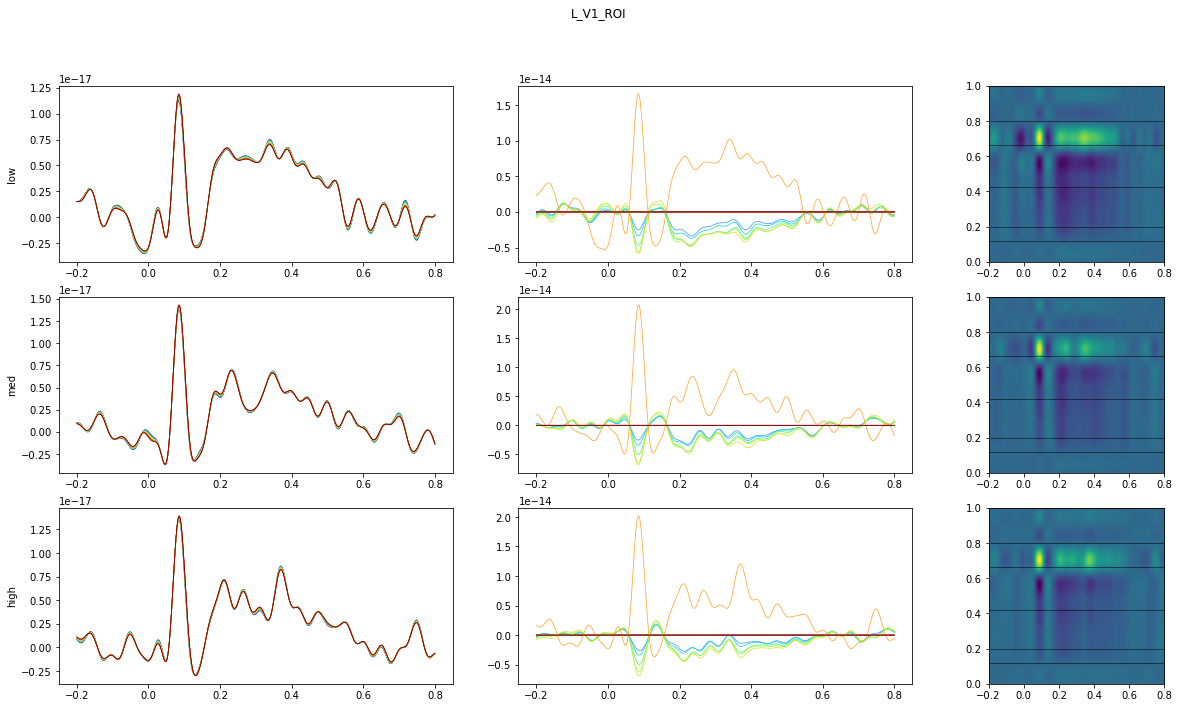

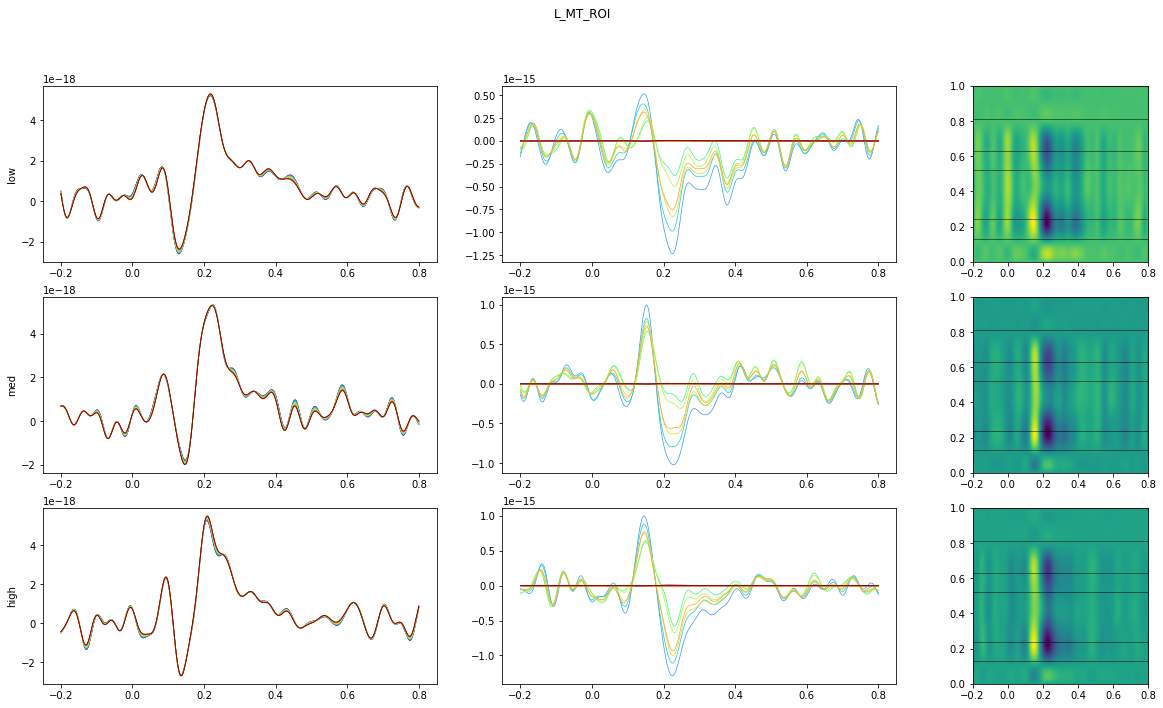

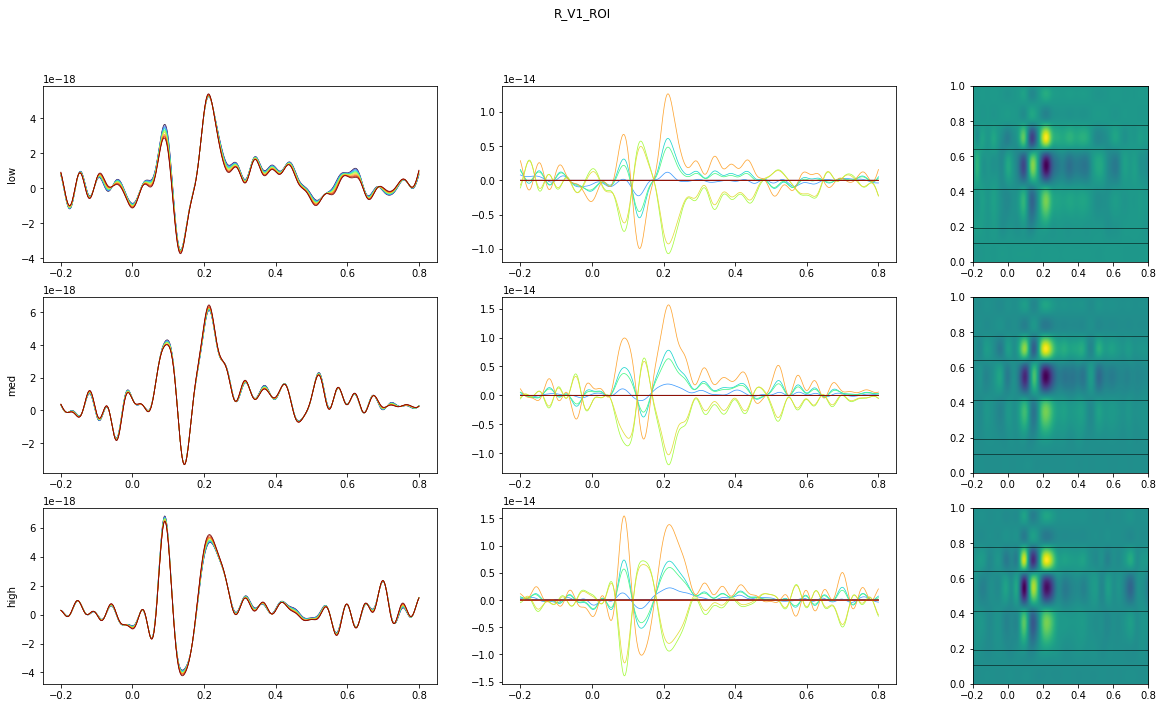

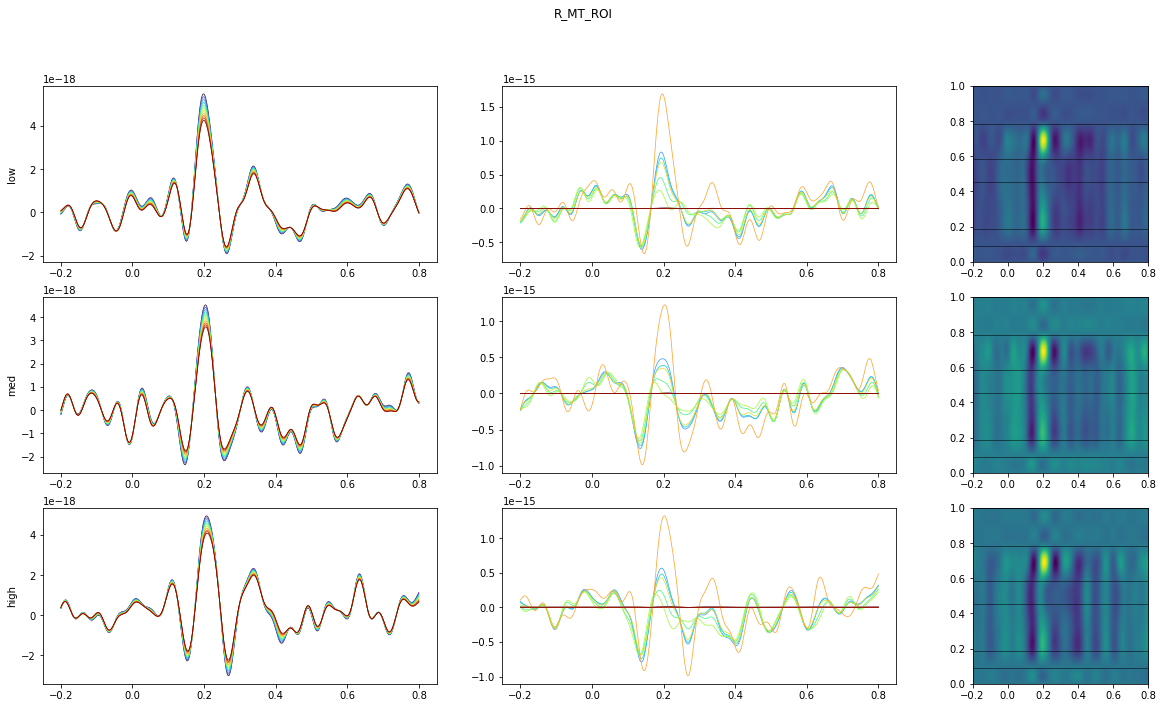

In [160]:
%matplotlib inline

n_surfs = 11
colour_range = plt.cm.turbo(np.linspace(0, 1, num=n_surfs))
for ix, lab in enumerate(target_labels):
    lab_vx_ix = np.arange(len(ROI_maps[lab]))[ROI_maps[lab]]
    
    layer_thiccness = []
    for lay in layers_prop_thickness.keys():
        layer_thiccness.append(layers_prop_thickness[lay][lab_vx_ix])
    layer_thiccness = np.array(layer_thiccness)
    mean_ROI_thicc = np.mean(np.cumsum(layer_thiccness, axis=0), axis=1)
    
    low, med, high = source[lab]
    std_vx = np.std(np.concatenate(source[lab], axis=1)[-1], axis=0)
    mean_std_vx = np.mean(std_vx, axis=0)
    peak_time = np.argmax(mean_std_vx)
    peak_vx = np.argmax(std_vx[:,peak_time])
    low_m, med_m, high_m = [np.mean(i[:,:,peak_vx,:], axis=1) for i in [low, med, high]]
    low_a, med_a, high_a = [i[:,:,peak_vx,:] for i in [low, med, high]]
    peak_distance = distance_ROI[lab_vx_ix[peak_vx]]
    
    csd_low_a = [compute_csd(low_a[:,i,:], times, peak_distance, n_surfs) for i in range(low_a.shape[1])]
    csd_med_a = [compute_csd(med_a[:,i,:], times, peak_distance, n_surfs) for i in range(med_a.shape[1])]
    csd_high_a = [compute_csd(high_a[:,i,:], times, peak_distance, n_surfs) for i in range(high_a.shape[1])]
    
    csd_smooth_low_a = [smooth_csd(i, n_surfs) for i in csd_low_a]
    csd_smooth_med_a = [smooth_csd(i, n_surfs) for i in csd_med_a]
    csd_smooth_high_a = [smooth_csd(i, n_surfs) for i in csd_high_a]
    
    csd_low_m = np.mean(csd_low_a, axis=0)
    csd_med_m = np.mean(csd_med_a, axis=0)
    csd_high_m = np.mean(csd_high_a, axis=0)
    
    csd_smooth_low_m = np.mean(csd_smooth_low_a, axis=0)
    csd_smooth_med_m = np.mean(csd_smooth_med_a, axis=0)
    csd_smooth_high_m = np.mean(csd_smooth_high_a, axis=0)
    
    f, ax = plt.subplots(3, 3, figsize=(20,11), gridspec_kw={'width_ratios': [0.4, 0.4, 0.2]})
    f.suptitle(lab)
    ax[0,0].set_ylabel("low")
    ax[1,0].set_ylabel("med")
    ax[2,0].set_ylabel("high")
    for s in range(n_surfs):
        ax[0,0].plot(times, low_m[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[1,0].plot(times, med_m[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[2,0].plot(times, high_m[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[0,1].plot(times, csd_low_m[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[1,1].plot(times, csd_med_m[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[2,1].plot(times, csd_high_m[s], lw=0.75, c=colour_range[s], label=s+1)
    ax[0,2].imshow(csd_smooth_low_m, origin="lower", extent=[times[0], times[-1], 0, 1])
    ax[1,2].imshow(csd_smooth_med_m, origin="lower", extent=[times[0], times[-1], 0, 1])
    ax[2,2].imshow(csd_smooth_high_m, origin="lower", extent=[times[0], times[-1], 0, 1])
    for l_ix,th in enumerate(mean_ROI_thicc):
        l_ix = l_ix+1
        ax[0,2].axhline(th, c="black", lw=0.5)
        ax[1,2].axhline(th, c="black", lw=0.5)
        ax[2,2].axhline(th, c="black", lw=0.5)

In [25]:
n_surfs = 11
results = {}
for ix, lab in enumerate(target_labels):
    lab_vx_ix = np.arange(len(ROI_maps[lab]))[ROI_maps[lab]]
    
    layer_thiccness = []
    for lay in layers_prop_thickness.keys():
        layer_thiccness.append(layers_prop_thickness[lay][lab_vx_ix])
    layer_thiccness = np.array(layer_thiccness)
    mean_ROI_thicc = np.mean(np.cumsum(layer_thiccness, axis=0), axis=1)
    
    low, med, high = source[lab]
    std_vx = np.std(np.concatenate(source[lab], axis=1)[-1], axis=0)
    mean_std_vx = np.mean(std_vx, axis=0)
    peak_time = np.argmax(mean_std_vx)
    peak_vx = np.argmax(std_vx[:,peak_time])
    low_m, med_m, high_m = [np.mean(i[:,:,peak_vx,:], axis=1) for i in [low, med, high]]
    low_a, med_a, high_a = [i[:,:,peak_vx,:] for i in [low, med, high]]
    peak_distance = distance_ROI[lab_vx_ix[peak_vx]]
    
    csd_low_a = [compute_csd(low_a[:,i,:], times, peak_distance, n_surfs) for i in range(low_a.shape[1])]
    csd_med_a = [compute_csd(med_a[:,i,:], times, peak_distance, n_surfs) for i in range(med_a.shape[1])]
    csd_high_a = [compute_csd(high_a[:,i,:], times, peak_distance, n_surfs) for i in range(high_a.shape[1])]
    
    csd_smooth_low_a = [smooth_csd(i, n_surfs) for i in csd_low_a]
    csd_smooth_med_a = [smooth_csd(i, n_surfs) for i in csd_med_a]
    csd_smooth_high_a = [smooth_csd(i, n_surfs) for i in csd_high_a]
    
    csd_low_m = np.mean(csd_low_a, axis=0)
    csd_med_m = np.mean(csd_med_a, axis=0)
    csd_high_m = np.mean(csd_high_a, axis=0)
    
    csd_smooth_low_m = np.mean(csd_smooth_low_a, axis=0)
    csd_smooth_med_m = np.mean(csd_smooth_med_a, axis=0)
    csd_smooth_high_m = np.mean(csd_smooth_high_a, axis=0)
    results[lab] = [
        low_m,
        med_m,
        high_m,
        csd_low_m,
        csd_med_m,
        csd_high_m,
        csd_smooth_low_m,
        csd_smooth_med_m,
        csd_smooth_high_m,
        peak_distance,
        layer_thiccness
    ]

L_V1_ROI
L_MT_ROI
R_V1_ROI
R_MT_ROI


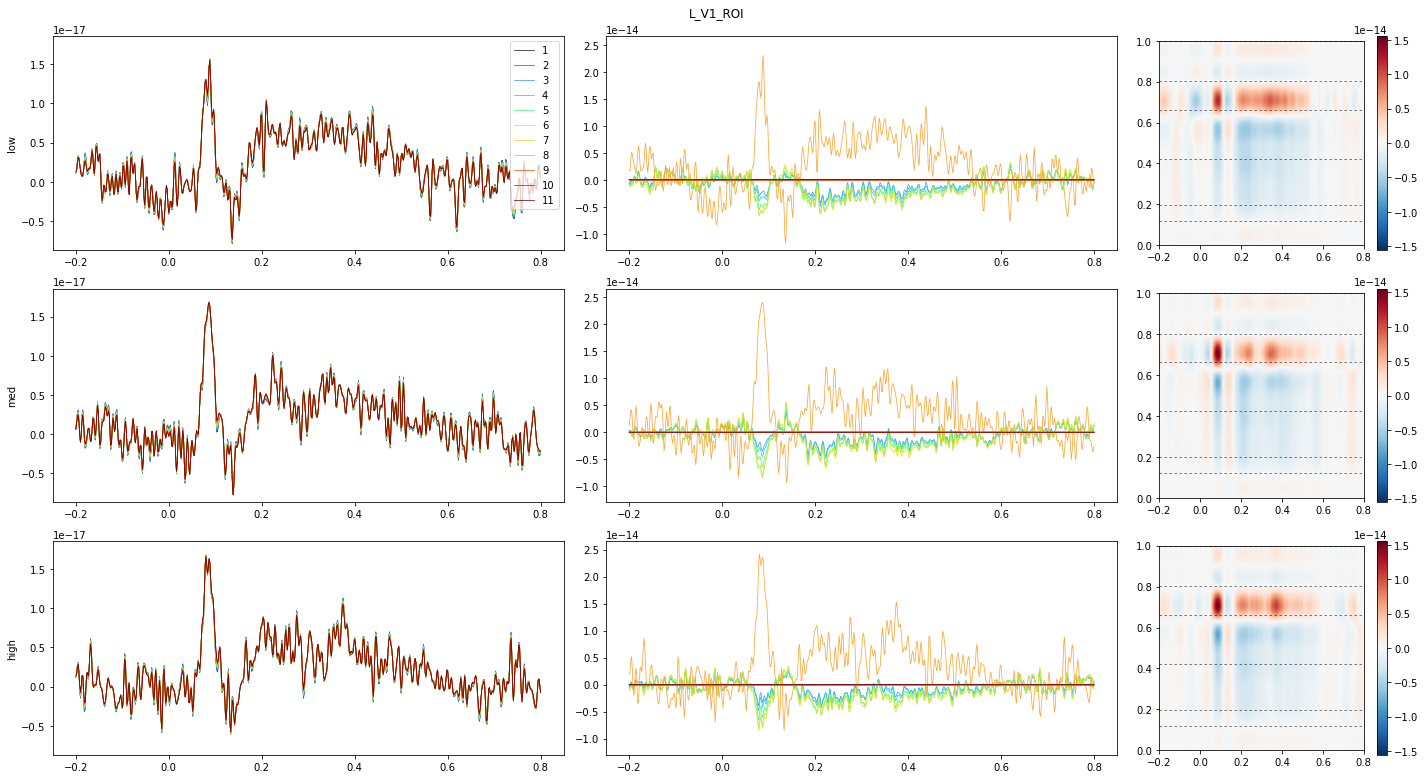

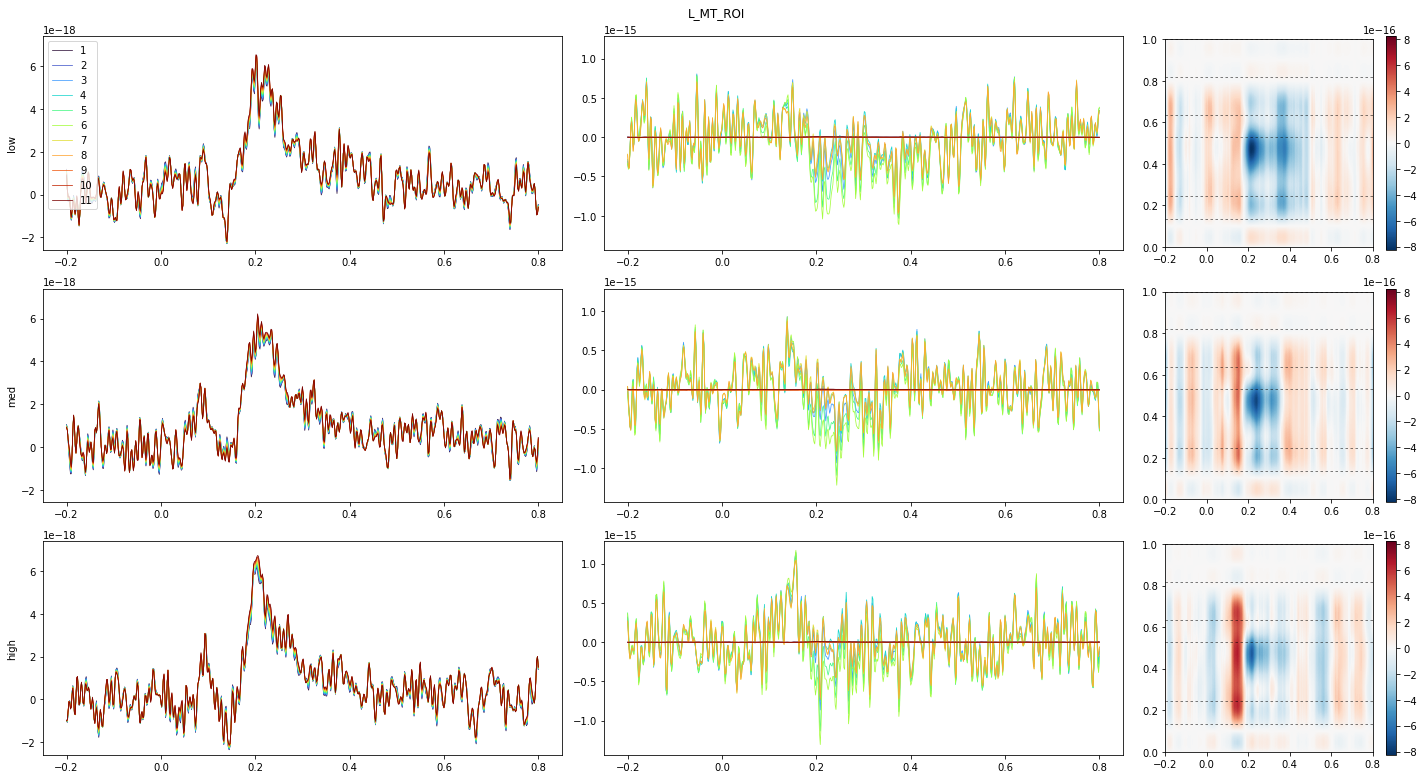

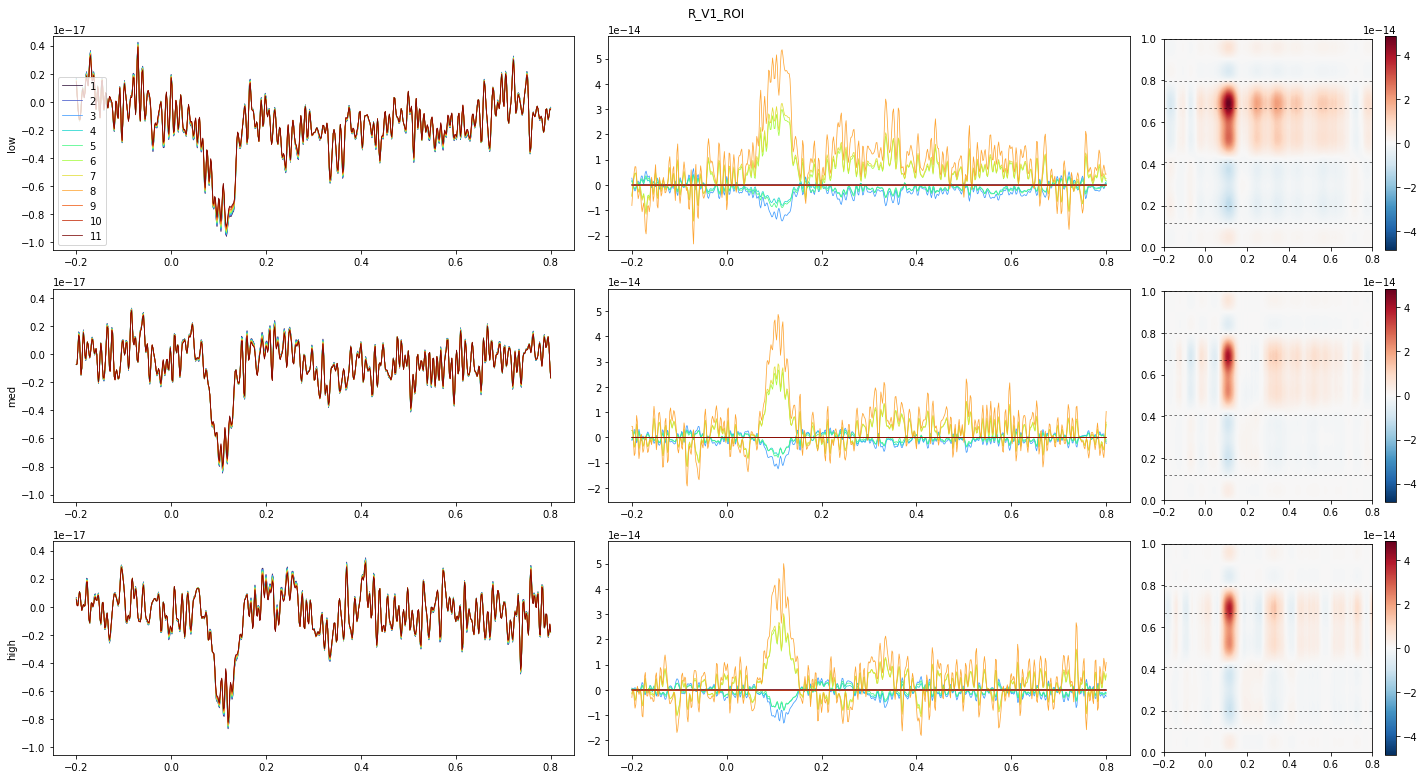

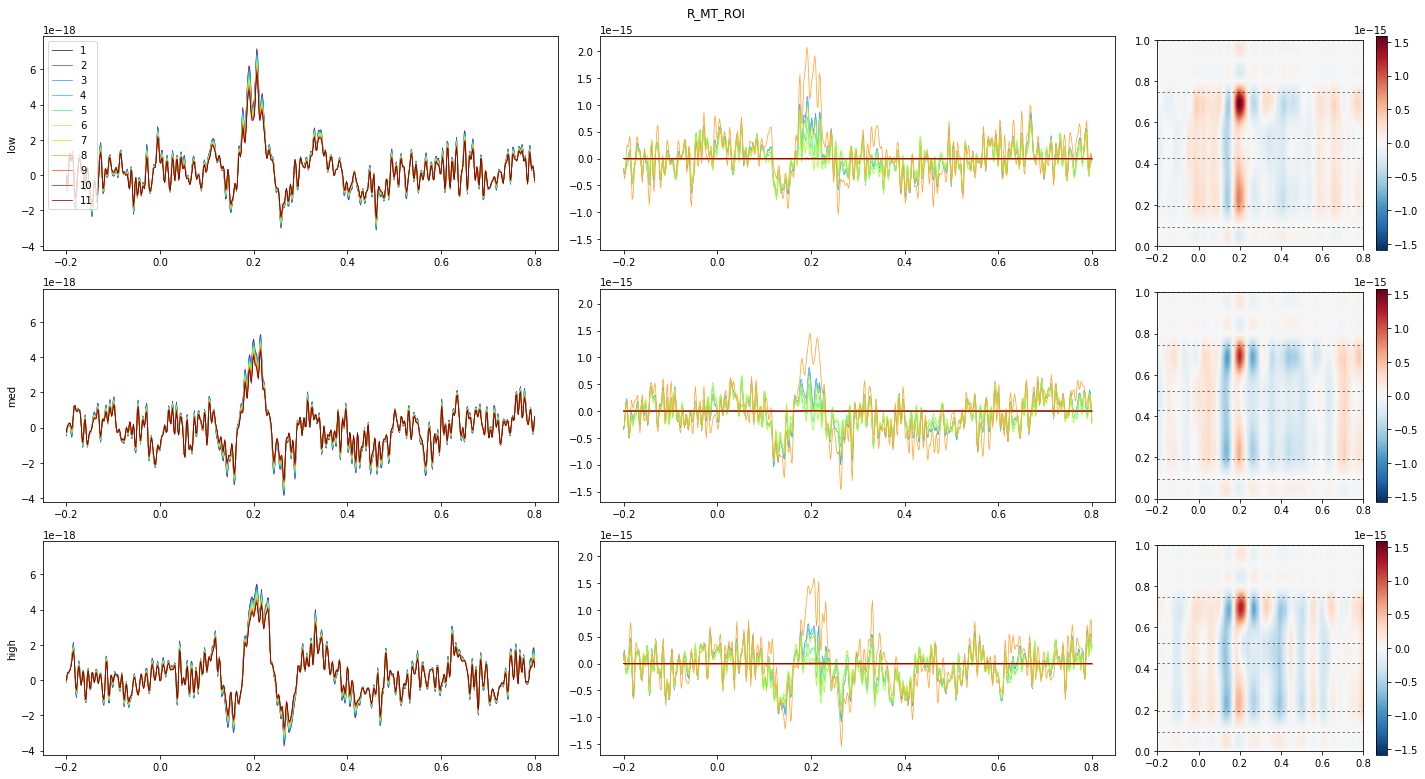

In [44]:
%matplotlib inline
colour_range = plt.cm.turbo(np.linspace(0, 1, num=n_surfs))
for ix, lab in enumerate(target_labels):
    print(lab)
    [
        low_m, med_m, high_m,
        csd_low_m, csd_med_m, csd_high_m,
        csd_smooth_low_m, csd_smooth_med_m, csd_smooth_high_m, peak_distance,
        layer_thiccness
    ] = results[lab]
    all_epo = np.concatenate([low_m, med_m, high_m])
    all_csd = np.concatenate([csd_low_m, csd_med_m, csd_high_m])
    all_smooth = np.concatenate([csd_smooth_low_m, csd_smooth_med_m, csd_smooth_high_m])
    max_smooth = np.max(np.abs(all_smooth))
    mean_ROI_thicc = np.mean(np.cumsum(layer_thiccness, axis=0), axis=1)
    divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    f, ax = plt.subplots(3, 3, figsize=(20,11), gridspec_kw={'width_ratios': [0.4, 0.4, 0.2]}, facecolor="white",)
    f.suptitle(lab)
    ax[0,0].set_ylabel("low")
    ax[1,0].set_ylabel("med")
    ax[2,0].set_ylabel("high")
    for s in range(n_surfs):
        ax[0,0].plot(times, low_m[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[1,0].plot(times, med_m[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[2,0].plot(times, high_m[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[0,1].plot(times, csd_low_m[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[1,1].plot(times, csd_med_m[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[2,1].plot(times, csd_high_m[s], lw=0.75, c=colour_range[s], label=s+1)
        ax[0,0].set_ylim(np.min(all_epo)*1.1, np.max(all_epo)*1.1)
        ax[1,0].set_ylim(np.min(all_epo)*1.1, np.max(all_epo)*1.1)
        ax[2,0].set_ylim(np.min(all_epo)*1.1, np.max(all_epo)*1.1)
        ax[0,1].set_ylim(np.min(all_csd)*1.1, np.max(all_csd)*1.1)
        ax[1,1].set_ylim(np.min(all_csd)*1.1, np.max(all_csd)*1.1)
        ax[2,1].set_ylim(np.min(all_csd)*1.1, np.max(all_csd)*1.1)
    im = ax[0,2].imshow(csd_smooth_low_m, norm=divnorm, origin="lower", extent=[times[0], times[-1], 0, 1], cmap="RdBu_r")
    cbar = plt.colorbar(im, ax=ax[0,2])
    ax[1,2].imshow(csd_smooth_med_m, norm=divnorm, origin="lower", extent=[times[0], times[-1], 0, 1], cmap="RdBu_r")
    cbar = plt.colorbar(im, ax=ax[1,2])
    ax[2,2].imshow(csd_smooth_high_m, norm=divnorm, origin="lower", extent=[times[0], times[-1], 0, 1], cmap="RdBu_r")
    cbar = plt.colorbar(im, ax=ax[2,2])
    for l_ix,th in enumerate(mean_ROI_thicc):
        l_ix = l_ix+1
        ax[0,2].axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
        ax[1,2].axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
        ax[2,2].axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
    ax[0,0].legend()
    plt.tight_layout()
    plt.savefig("output/{}.svg".format(lab))

In [31]:
np.concatenate([low_m, med_m, high_m])

array([[ 1.10417210e-18,  1.39182470e-18,  2.62330118e-18, ...,
         2.21218101e-18,  1.25340834e-18,  6.37828294e-19],
       [ 1.12673553e-18,  1.39759654e-18,  2.59755100e-18, ...,
         2.20013515e-18,  1.24439867e-18,  6.05726218e-19],
       [ 1.14840177e-18,  1.40210052e-18,  2.57060235e-18, ...,
         2.18684882e-18,  1.23462315e-18,  5.73965591e-19],
       ...,
       [ 1.38330276e-18,  1.56072681e-18,  2.47084230e-18, ...,
         9.73407661e-19,  1.99770902e-19, -7.36935309e-19],
       [ 1.41418091e-18,  1.56851115e-18,  2.46282508e-18, ...,
         9.85553692e-19,  2.00834616e-19, -7.46743279e-19],
       [ 1.43537776e-18,  1.56627977e-18,  2.43965742e-18, ...,
         9.91812503e-19,  2.01163921e-19, -7.50753931e-19]])